In [16]:
# Generic imports
import copy
import os
import scipy.interpolate
from mpl_toolkits.mplot3d import Axes3D
from numpy import \
matrix, linspace, meshgrid, sin, cos, array, sqrt, pi, diff, mean, median, std, arcsin, zeros, random, \
size, reshape, shape, vstack, eye, diag, nan_to_num, ones, loadtxt, savetxt, append, squeeze
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image, ImageFont, ImageDraw
import f90nml

# Application-specific imports
import facetbrightnessstuff9 as fbs
import imagestuff as ims
import gradstuff as gds

# Graphics imports and parameters
#%matplotlib inline
%matplotlib notebook
fontsize = 20
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [3]:
# Parameters
ABCDangle_deg = 15.0
theta = ABCDangle_deg*pi/180

fontsize = 20
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})
fnt = ImageFont.load_default()

In [18]:
# Specify the input data -- one of these blocks needs to be active

# Assume all the data are in the same folder
crystalfolder = 'crystals'

f1 = '2016-08-09_ice1'
case = 'calibration'
imageroot = '/2016-08-09_ice1_full2'
Boxesnamelist = 'Boxes.nml'



In [22]:
# These are derivative names
Calibrationfile = crystalfolder+'/'+f1+'/Calibration.nml'
surfaceroot = crystalfolder+'/'+f1+'/'+case
Boxesfile = surfaceroot+'/'+Boxesnamelist

In [23]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2(surfaceroot, '/SEMimages', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

('Filename, dx and dy', 'crystals/2016-08-09_ice1/calibration/SEMimages/2016-08-09_ice1_full2-D.bmp', 2.280891, 2.280891)


In [33]:
# Just echo input data files 
%cat $Boxesfile

&Boxes
    nx1list = 360,275,205
    ny1list = 245,85,310
    labellist = '*','x','+'
    boxsize = 40
/

&Vectors
    xorigin = 226; yorigin = 248
    xa = 304.;  ya = 388.
    xb = 199.;  yb = 204.
    xc = 377.;  yc = 161.
/



In [32]:
# Define boxes for calibration
Boxes=f90nml.read(Boxesfile) #reads the file at a given path
nx1list=Boxes['Boxes']['nx1list']
ny1list=Boxes['Boxes']['ny1list']
labellist=Boxes['Boxes']['labellist']
boxsize=Boxes['Boxes']['boxsize']
nboxes = len(nx1list)
nx2list = np.array(nx1list)+boxsize; ny2list = np.array(ny1list)+boxsize
print ("nboxes =", nboxes)

('nboxes =', 3)


In [34]:
# Define boxes for calibration
# Extract
Vectors=f90nml.read(Boxesfile) #reads the file at a given path
xorigin=Vectors['Vectors']['xorigin']
yorigin=Vectors['Vectors']['yorigin']

# # Orientation vectors
# xorigin = 226.; yorigin = 248.
# xa = 304.;  ya = 388.
# xb = 199.;  yb = 204.
# xc = 377.;  yc = 161.
# linea = [xorigin,yorigin,xa,ya]
# lineb = [xorigin,yorigin,xb,yb]
# linec = [xorigin,yorigin,xc,yc]


In [8]:

# Calculate normal vectors of the crystal
avec, bvec, cvec, navec, nbvec = fbs.solveforabc(\
                 xa-xorigin,ya-yorigin,\
                 xb-xorigin,yb-yorigin,\
                 xc-xorigin,yc-yorigin) # negative because this is the left hand side of the crystal
print 'unit normal a-facet =\n',navec
print 'unit normal b-facet =\n',nbvec

Rot28 = ims.myrotation_matrix(avec, -28.) # use avec or bvec depending on which one the pyramidal facet touches
ndvec = Rot28*navec # solverforabc gives this as already normalized 
print 'unit normal d-facet =\n',ndvec

# For each detector, get s-values
sAa, sBa, sCa, sDa = ims.mygets(navec,theta)
sAb, sBb, sCb, sDb = ims.mygets(nbvec,theta)
sAd, sBd, sCd, sDd = ims.mygets(ndvec,theta)
slistA = np.squeeze(np.array([sAa, sAb, sAd]))
slistB = np.squeeze(np.array([sBa, sBb, sBd]))
slistC = np.squeeze(np.array([sCa, sCb, sCd]))
slistD = np.squeeze(np.array([sDa, sDb, sDd]))

# For each detector, get s-values
sAa, sBa, sCa, sDa = ims.mygets(navec,theta)
sAb, sBb, sCb, sDb = ims.mygets(nbvec,theta)
sAd, sBd, sCd, sDd = ims.mygets(ndvec,theta)
slistA = np.squeeze(np.array([sAa, sAb, sAd]))
slistB = np.squeeze(np.array([sBa, sBb, sBd]))
slistC = np.squeeze(np.array([sCa, sCb, sCd]))
slistD = np.squeeze(np.array([sDa, sDb, sDd]))

# Extract the observed intensities
cA_obs = []
cB_obs = []
cC_obs = []
cD_obs = []
for isegment in range(nboxes):
    nx1=nx1list[isegment]; nx2=nx2list[isegment] 
    ny1=ny1list[isegment]; ny2=ny2list[isegment]
    cA_obs.append(np.mean(cA[ny1:ny2,nx1:nx2].astype('float')))
    cB_obs.append(np.mean(cB[ny1:ny2,nx1:nx2].astype('float')))
    cC_obs.append(np.mean(cC[ny1:ny2,nx1:nx2].astype('float')))
    cD_obs.append(np.mean(cD[ny1:ny2,nx1:nx2].astype('float')))

        
################################################################################################        
################################################################################################        
# Graph the segments
f3 = f1+'-A'
Filename = upperpath+f2+"/" +f3+'.bmp'
im = Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = ImageDraw.Draw(im)
draw.line(linea, fill=50,width=2)
draw.line(lineb, fill=40,width=2)
draw.line(linec, fill=0,width=2)
draw.text((xa-20,ya-20), 'a', font=fnt)
draw.text((xb-20,yb+20), 'b', font=fnt)   

fig, ax = plt.subplots()
for i in range(nboxes):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectanglelabel(draw,(nx1,ny1),(nx2,ny2),labellist[i])
ax.set_title(f3,fontsize=fontsize*0.9)
Iwantmicrons = False
if Iwantmicrons:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255, extent=[0,nx_im*dx,0,ny_im*dy])
    ax.set_xlabel(r'$x \ (\mu m)$',fontsize=fontsize*1.1)
    ax.set_ylabel(r'$y \ (\mu m)$',fontsize=fontsize*1.1)
else:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)


NameError: name 'Boxesfile' is not defined

<IPython.core.display.Javascript object>


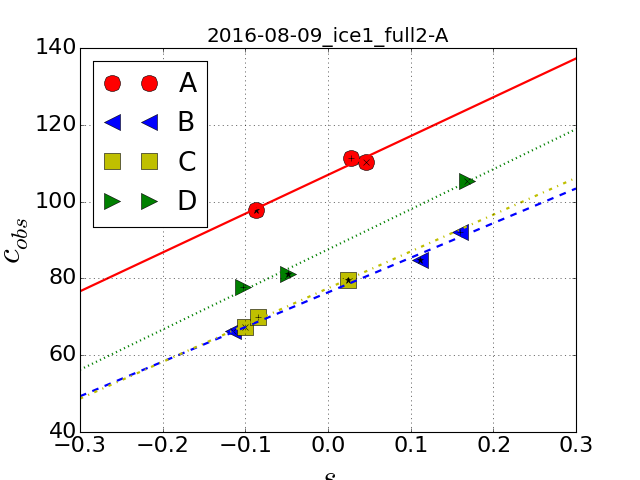

pA = 101.04798753 , 106.958873177
pB = 90.1823777937 , 76.3561483181
pC = 95.8244330336 , 77.4315996502
pD = 104.429731424 , 87.5491460912


In [33]:
# See what these look like graphically
plt.figure()
markersize = 10
plt.plot(slistA,cA_obs,'or',markersize=15)
plt.plot(slistB,cB_obs,'<b',markersize=15)
plt.plot(slistC,cC_obs,'sy',markersize=15)
plt.plot(slistD,cD_obs,'>g',markersize=15)
plt.legend(['A', 'B', 'C', 'D'],loc='upper left')
plt.plot(slistA[0],cA_obs[0],'k*')
plt.plot(slistA[1],cA_obs[1],'kx')
plt.plot(slistA[2],cA_obs[2],'k+')
plt.plot(slistB[0],cB_obs[0],'k*')
plt.plot(slistB[1],cB_obs[1],'kx')
plt.plot(slistB[2],cB_obs[2],'k+')
plt.plot(slistC[0],cC_obs[0],'k*')
plt.plot(slistC[1],cC_obs[1],'kx')
plt.plot(slistC[2],cC_obs[2],'k+')
plt.plot(slistD[0],cD_obs[0],'k*')
plt.plot(slistD[1],cD_obs[1],'kx')
plt.plot(slistD[2],cD_obs[2],'k+')
# plt.plot(slistB[-1],cB_obs[-1],'*b')
# plt.plot(slistC[-1],cC_obs[-1],'*y')
# plt.plot(slistD[-1],cD_obs[-1],'*g')
plt.grid()
srange = [-.3,.3]
plt.xlim(srange)
plt.xlabel('$s$',fontsize=fontsize*1.5)
plt.ylabel('$c_{obs}$',fontsize=fontsize*1.5)


# Fitting
maxorder = 1
order = min(len(slistA)-1,maxorder)
pA = np.polyfit(slistA,cA_obs,order); print 'pA =', pA[0], ',', pA[1]
pB = np.polyfit(slistB,cB_obs,order); print 'pB =', pB[0], ',', pB[1]
pC = np.polyfit(slistC,cC_obs,order); print 'pC =', pC[0], ',', pC[1]
pD = np.polyfit(slistD,cD_obs,order); print 'pD =', pD[0], ',', pD[1]
s_theory = np.linspace(srange[0],srange[1])
cA_theory = np.polyval(pA,s_theory)
cB_theory = np.polyval(pB,s_theory)
cC_theory = np.polyval(pC,s_theory)
cD_theory = np.polyval(pD,s_theory)
plt.plot(s_theory,cA_theory,'-r',linewidth=linewidth)
plt.plot(s_theory,cB_theory,'--b',linewidth=linewidth)
plt.plot(s_theory,cC_theory,'-.y',linewidth=linewidth)
plt.plot(s_theory,cD_theory,':g',linewidth=linewidth)
plt.title(f3,fontsize=fontsize*0.9)

In [29]:
Iwantstlp = True
if Iwantstlp:
    filename = 'temp_facetnormals.npz'
    np.savez(filename, 
          navec=navec, 
          nbvec=nbvec,
          cvec=cvec) #then open makestlp.py to make actual .stl file and view it using glc player or other program

In [30]:
print slistB
print slistB[0]

[ 0.11154023 -0.11463933  0.15967409]
0.111540234757
